In [52]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [53]:
import nltk
nltk.download('punkt')
import nltk

# Download the 'punkt' resource
nltk.download('punkt')

# If you need the stopwords resource as well, you can download it with:
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [54]:
# Load the dataset (assuming you have 'movie_dataset.csv' as before)
df = pd.read_csv('movie_train.csv')

In [55]:
df.shape

(22579, 3)

In [56]:
df

,id,text,genre
0,0,"eady dead, maybe even wishing he was. INT. 2ND...",thriller
1,2,"t, summa cum laude and all. And I'm about to l...",comedy
2,3,"up Come, I have a surprise.... She takes him ...",drama
3,4,ded by the two detectives. INT. JEFF'S APARTME...,thriller
4,5,"nd dismounts, just as the other children reach...",drama
...,...,...,...
22574,28161,n in the world to decide what I'm going to do ...,drama
22575,28162,shards. BOJO LAZ! Laz pushes Deke back through...,drama
22576,28163,"OTTIE You've got a thing about Ernie's, haven'...",thriller
22577,28165,....with marked skill and dexterity . LANA wry...,action


In [57]:
df['genre'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 22579 entries, 0 to 22578
Series name: genre
Non-Null Count  Dtype 
--------------  ----- 
22579 non-null  object
dtypes: object(1)
memory usage: 176.5+ KB


In [58]:
df.genre.value_counts()

drama        8873
thriller     6824
comedy       2941
action       2392
sci-fi        613
horror        456
other         270
adventure     147
romance        63
Name: genre, dtype: int64

In [59]:
df.columns

Index(['id', 'text', 'genre'], dtype='object')

In [60]:
df.head(5)

,id,text,genre
0,0,"eady dead, maybe even wishing he was. INT. 2ND...",thriller
1,2,"t, summa cum laude and all. And I'm about to l...",comedy
2,3,"up Come, I have a surprise.... She takes him ...",drama
3,4,ded by the two detectives. INT. JEFF'S APARTME...,thriller
4,5,"nd dismounts, just as the other children reach...",drama


In [61]:
df.tail(5)

,id,text,genre
22574,28161,n in the world to decide what I'm going to do ...,drama
22575,28162,shards. BOJO LAZ! Laz pushes Deke back through...,drama
22576,28163,"OTTIE You've got a thing about Ernie's, haven'...",thriller
22577,28165,....with marked skill and dexterity . LANA wry...,action
22578,28166,"rd walks off down the hallway, leaving his pos...",comedy


In [62]:
len(df['genre'].unique())

9

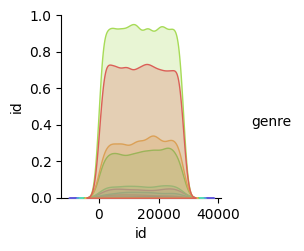

In [63]:
sns.pairplot(df, hue='genre', palette='hls')
plt.show()

<Axes: >

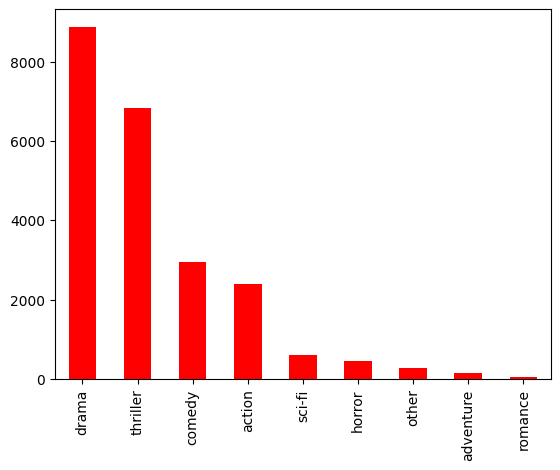

In [64]:
df.genre.value_counts().plot.bar(color="red")

In [65]:
# Text preprocessing function (same as before)
def preprocess_text(text):
    # Remove special characters and digits
    text = re.sub(r'[^\w\s]', '', str(text))
    text = re.sub(r'\d+', '', text)

    # Convert text to lowercase
    text = text.lower()

    # Tokenize the text
    words = word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Apply stemming
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]

    return ' '.join(words)

# Apply text preprocessing to the "description" column
df['description_cleaned_text'] = df['text'].apply(preprocess_text)

In [66]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MultiLabelBinarizer

X_train, X_test, y_train, y_test = train_test_split(df['description_cleaned_text'], df['genre'], test_size=0.2, random_state=42)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_length = max(len(seq) for seq in X_train_seq)
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length)

mlb = MultiLabelBinarizer()
y_train_encoded = mlb.fit_transform(y_train.apply(lambda x: str(x).split(',')))
y_test_encoded = mlb.transform(y_test.apply(lambda x: str(x).split(',')))

In [67]:
# Define the LSTM model
embedding_dim = 100
vocab_size = len(tokenizer.word_index) + 1

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
model.add(LSTM(128))

model.add(Dense(len(mlb.classes_), activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
batch_size = 32
epochs = 10
history=model.fit(X_train_padded, y_train_encoded, batch_size=batch_size, epochs=epochs, validation_data=(X_test_padded, y_test_encoded))

Epoch 1/10
565/565 [==============================] - 255s 397ms/step - loss: 0.2706 - accuracy: 0.3858 - val_loss: 0.2633 - val_accuracy: 0.3815
Epoch 2/10
565/565 [==============================] - 213s 378ms/step - loss: 0.2321 - accuracy: 0.5253 - val_loss: 0.1834 - val_accuracy: 0.6455
Epoch 3/10
565/565 [==============================] - 202s 358ms/step - loss: 0.1071 - accuracy: 0.8212 - val_loss: 0.0963 - val_accuracy: 0.8392
Epoch 4/10
565/565 [==============================] - 212s 374ms/step - loss: 0.0488 - accuracy: 0.9214 - val_loss: 0.0867 - val_accuracy: 0.8576
Epoch 5/10
565/565 [==============================] - 203s 360ms/step - loss: 0.0270 - accuracy: 0.9579 - val_loss: 0.0826 - val_accuracy: 0.8744
Epoch 6/10
565/565 [==============================] - 215s 380ms/step - loss: 0.0164 - accuracy: 0.9742 - val_loss: 0.0815 - val_accuracy: 0.8804
Epoch 7/10
565/565 [==============================] - 213s 377ms/step - loss: 0.0108 - accuracy: 0.9847 - val_loss: 0.0900 -

In [68]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_padded, y_test_encoded, batch_size=batch_size)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

142/142 [==============================] - 13s 92ms/step - loss: 0.0943 - accuracy: 0.8957
Test Loss: 0.0943
Test Accuracy: 0.8957


graphs for accuracy

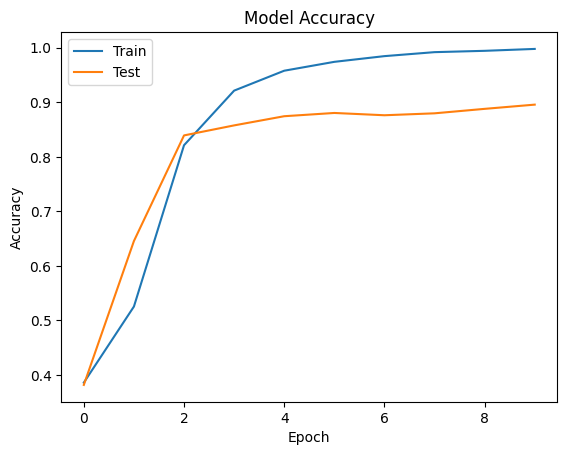

In [69]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])  # Use 'accuracy' instead of 'acc'
plt.plot(history.history['val_accuracy'])  # Use 'val_accuracy' instead of 'val_acc'
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


precession recall curves

142/142 [==============================] - 13s 92ms/step


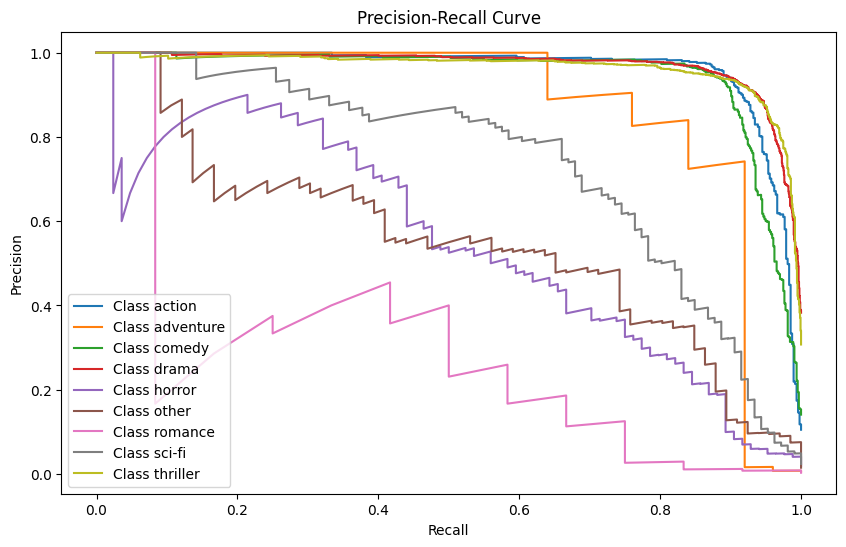

In [70]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

# Get predicted probabilities for the test set
y_pred_prob = model.predict(X_test_padded)

# Compute precision-recall curve for each class
precision = dict()
recall = dict()
thresholds = dict()
for i in range(len(mlb.classes_)):
    precision[i], recall[i], thresholds[i] = precision_recall_curve(y_test_encoded[:, i], y_pred_prob[:, i])

# Plot precision-recall curves
plt.figure(figsize=(10, 6))
for i in range(len(mlb.classes_)):
    plt.plot(recall[i], precision[i], label=f'Class {mlb.classes_[i]}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()


confusion metrics

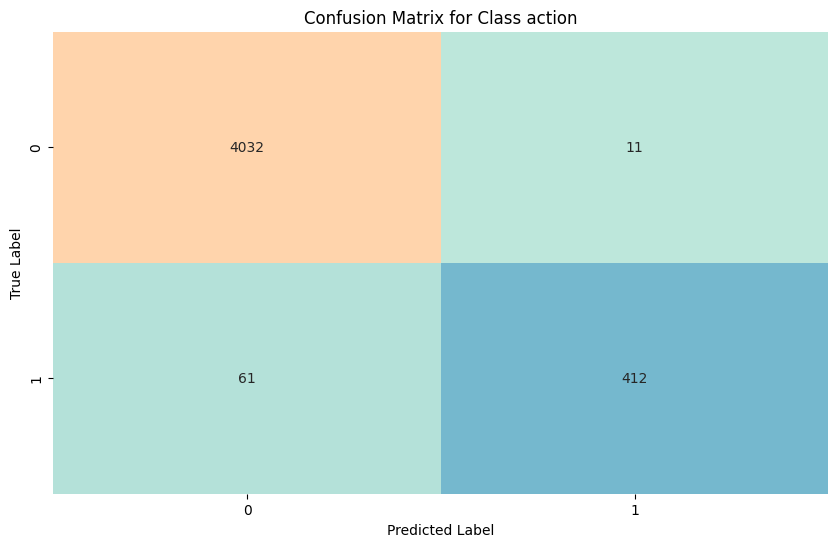

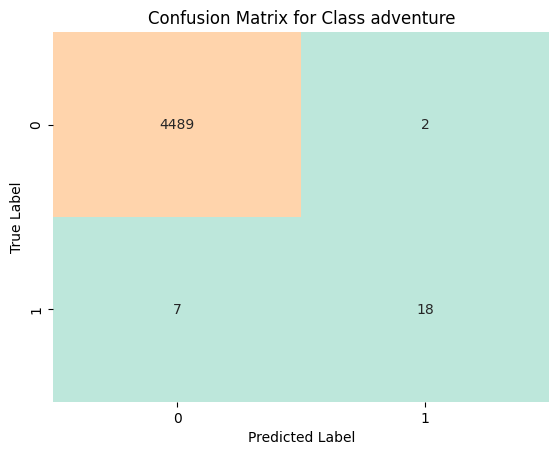

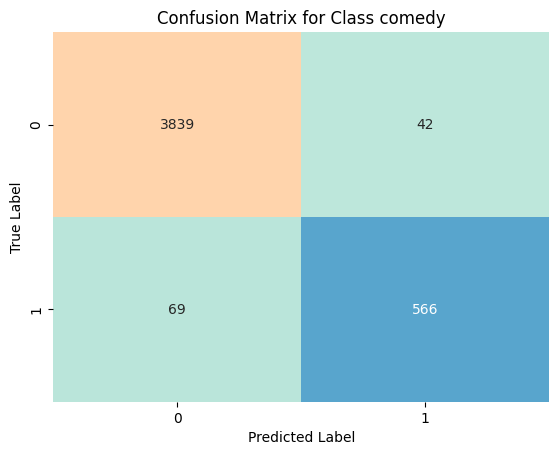

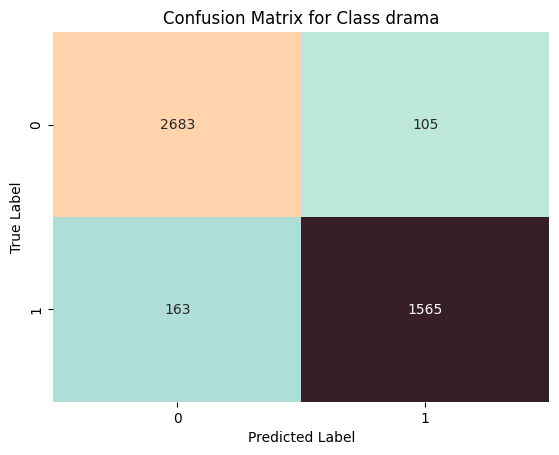

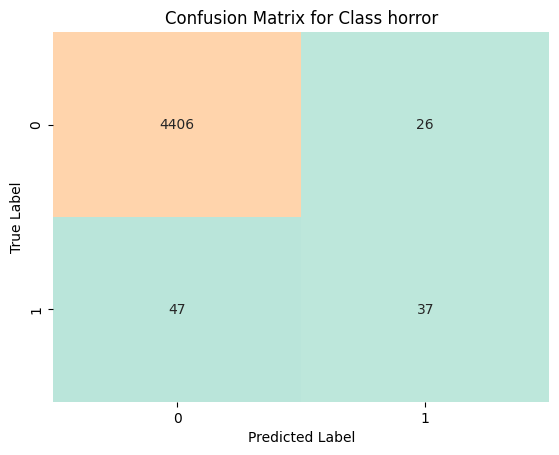

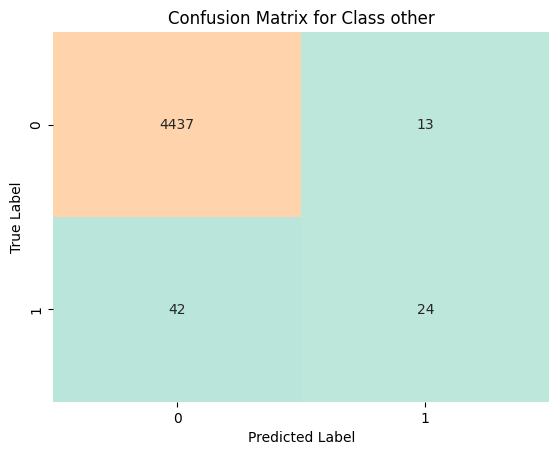

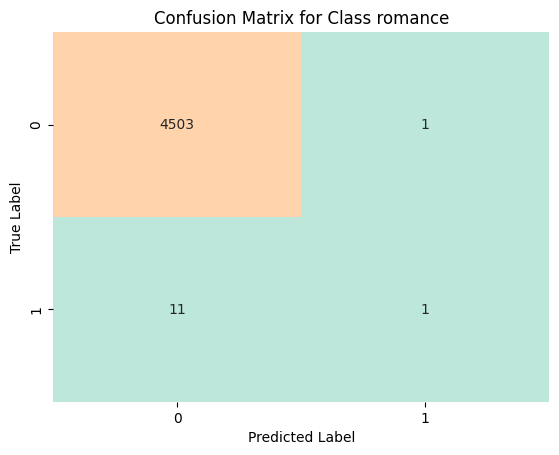

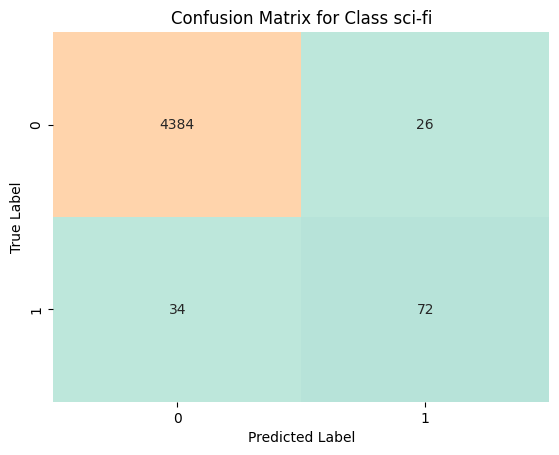

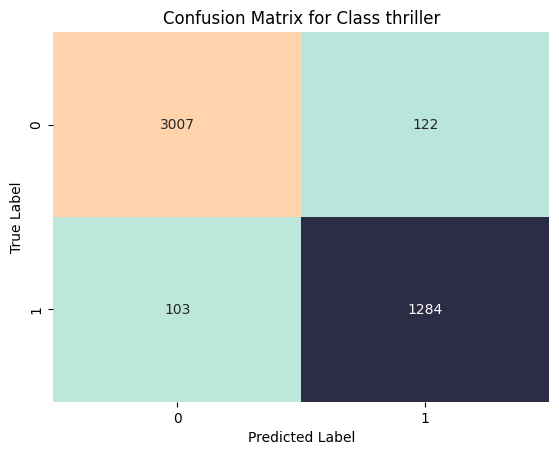

In [86]:
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns

# Convert probabilities to binary predictions
y_pred_binary = (y_pred_prob > 0.5).astype(int)

# Compute confusion matrix
cm = multilabel_confusion_matrix(y_test_encoded, y_pred_binary)

# Plot confusion matrix for each class
plt.figure(figsize=(10, 6))
for i in range(len(mlb.classes_)):
    sns.heatmap(cm[i], annot=True, fmt='d', cmap="icefire", cbar=False)
    plt.title(f'Confusion Matrix for Class {mlb.classes_[i]}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


In [88]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, multilabel_confusion_matrix

# Compute metrics
accuracy = accuracy_score(y_test_encoded, y_pred_binary)
precision = precision_score(y_test_encoded, y_pred_binary, average='micro')
recall = recall_score(y_test_encoded, y_pred_binary, average='micro')
f1 = f1_score(y_test_encoded, y_pred_binary, average='micro')
roc_auc = roc_auc_score(y_test_encoded, y_pred_prob)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Area under ROC Curve: {roc_auc:.4f}")

Test Accuracy: 0.8751
Precision: 0.9196
Recall: 0.8811
F1 Score: 0.8999
Area under ROC Curve: 0.9714


In [89]:
# Compute accuracy
accuracy = accuracy_score(y_test_encoded, y_pred_binary)
print(f"Test Accuracy: {accuracy:.4f}")

# Compute metrics with different averaging methods
precision_micro = precision_score(y_test_encoded, y_pred_binary, average='micro')
recall_micro = recall_score(y_test_encoded, y_pred_binary, average='micro')
f1_micro = f1_score(y_test_encoded, y_pred_binary, average='micro')

precision_macro = precision_score(y_test_encoded, y_pred_binary, average='macro')
recall_macro = recall_score(y_test_encoded, y_pred_binary, average='macro')
f1_macro = f1_score(y_test_encoded, y_pred_binary, average='macro')

precision_weighted = precision_score(y_test_encoded, y_pred_binary, average='weighted')
recall_weighted = recall_score(y_test_encoded, y_pred_binary, average='weighted')
f1_weighted = f1_score(y_test_encoded, y_pred_binary, average='weighted')

precision_samples = precision_score(y_test_encoded, y_pred_binary, average='samples')
recall_samples = recall_score(y_test_encoded, y_pred_binary, average='samples')
f1_samples = f1_score(y_test_encoded, y_pred_binary, average='samples')

print(f"Micro-averaged Precision: {precision_micro:.4f}, Recall: {recall_micro:.4f}, F1 Score: {f1_micro:.4f}")
print(f"Macro-averaged Precision: {precision_macro:.4f}, Recall: {recall_macro:.4f}, F1 Score: {f1_macro:.4f}")
print(f"Weighted-averaged Precision: {precision_weighted:.4f}, Recall: {recall_weighted:.4f}, F1 Score: {f1_weighted:.4f}")
print(f"Sample-averaged Precision: {precision_samples:.4f}, Recall: {recall_samples:.4f}, F1 Score: {f1_samples:.4f}")





Test Accuracy: 0.8751
Micro-averaged Precision: 0.9196, Recall: 0.8811, F1 Score: 0.8999
Macro-averaged Precision: 0.7918, Recall: 0.6534, F1 Score: 0.6988
Weighted-averaged Precision: 0.9159, Recall: 0.8811, F1 Score: 0.8968
Sample-averaged Precision: 0.8781, Recall: 0.8811, F1 Score: 0.8791


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


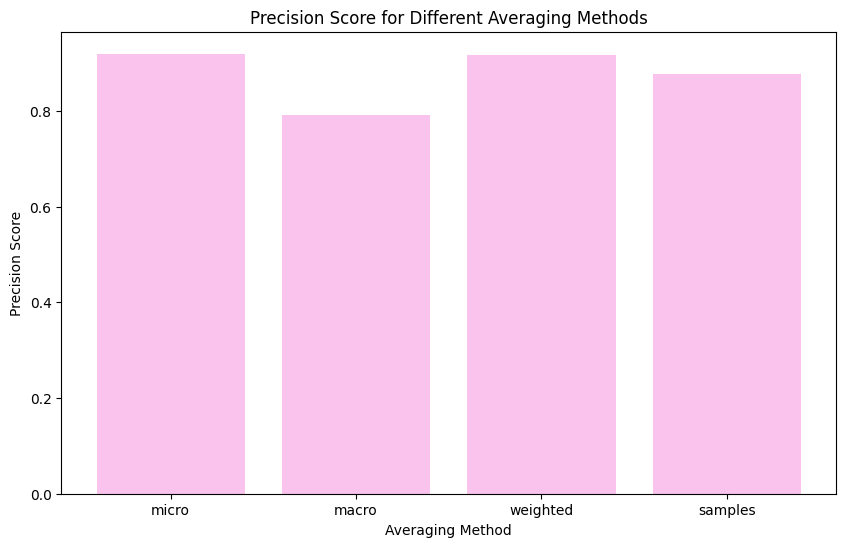

In [97]:
# Compute metrics with different averaging methods
metrics = ['micro', 'macro', 'weighted', 'samples']
precision_scores = [precision_score(y_test_encoded, y_pred_binary, average=avg) for avg in metrics]
recall_scores = [recall_score(y_test_encoded, y_pred_binary, average=avg) for avg in metrics]
f1_scores = [f1_score(y_test_encoded, y_pred_binary, average=avg) for avg in metrics]

# Plot bar plots for precision, recall, and F1 score
plt.figure(figsize=(10, 6))
plt.bar(metrics, precision_scores,color="#fac3ee")
plt.xlabel('Averaging Method')
plt.ylabel('Precision Score')
plt.title('Precision Score for Different Averaging Methods')
plt.show()


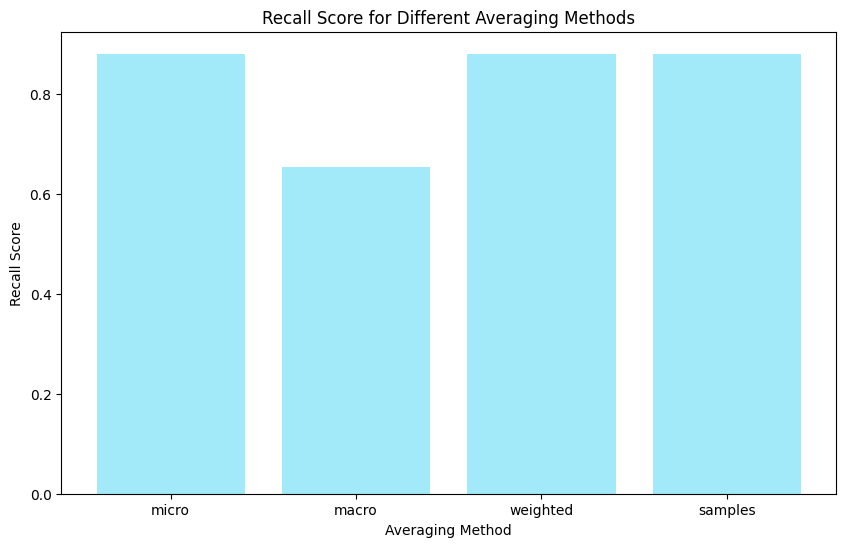

In [96]:

plt.figure(figsize=(10, 6))
plt.bar(metrics, recall_scores,color="#a2eafa")
plt.xlabel('Averaging Method')
plt.ylabel('Recall Score')
plt.title('Recall Score for Different Averaging Methods')
plt.show()

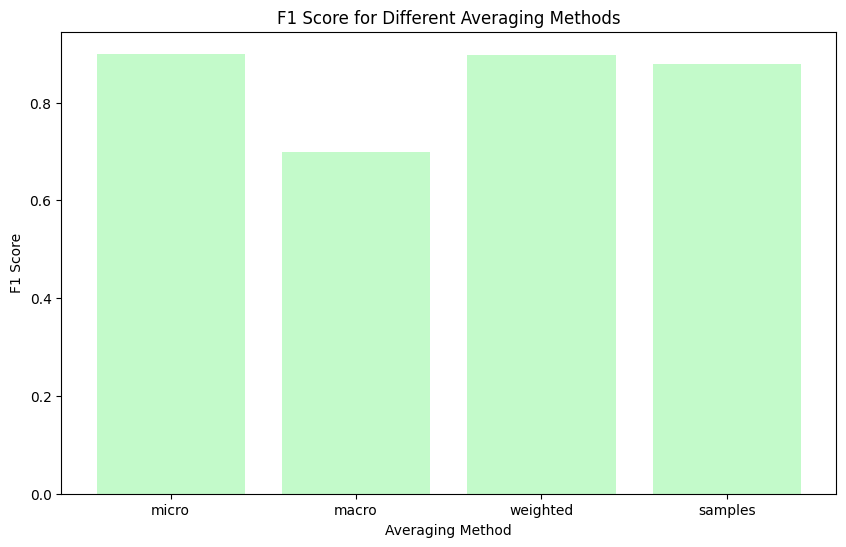

In [98]:

plt.figure(figsize=(10, 6))
plt.bar(metrics, f1_scores,color="#c3faca")
plt.xlabel('Averaging Method')
plt.ylabel('F1 Score')
plt.title('F1 Score for Different Averaging Methods')
plt.show()

In [72]:
import pandas as pd

# Read the input CSV file containing descriptions
input_file = 'input_plot.csv'
input_df = pd.read_csv(input_file)

In [73]:
# Preprocess the descriptions using the same preprocessing function
input_df['cleaned_text'] = input_df['Plot'].apply(preprocess_text)

In [74]:
# Convert preprocessed descriptions into sequences using the Tokenizer
X_input_seq = tokenizer.texts_to_sequences(input_df['cleaned_text'])

In [75]:
# Pad the sequences to the same maximum length used during training
X_input_padded = pad_sequences(X_input_seq, maxlen=max_length)

In [76]:
# Use the trained model to predict the genres for the preprocessed descriptions
y_input_pred = model.predict(X_input_padded)

1/1 [==============================] - 0s 56ms/step


In [77]:
# Convert the predicted probabilities into binary labels using a threshold (e.g., 0.5)
threshold = 0.5
y_input_pred_labels = (y_input_pred > threshold).astype(int)

In [78]:
# Inverse transform the binary labels back to genre strings
y_input_pred_genres = mlb.inverse_transform(y_input_pred_labels)

In [79]:
# Create a new DataFrame with the input descriptions and predicted genres
output_df = pd.DataFrame({'Plot': input_df['Plot'], 'predicted_genre': [','.join(genres) for genres in y_input_pred_genres]})

In [80]:
# Save the predictions to a new CSV file
output_file = 'predicted_movie_genres.csv'
output_df.to_csv(output_file, index=False)